# SPEED analysis

First we ASSEMBLE it, after that its been LABELED. Then its PACKAGED and these going into a CARTON. At last the Cartons get PALLETIZED   
It goes from Assembly (Harro Hoefliger) to Labeler (Krones) to Packaging (Schubert Verpacker) to Cartoner (Pester Umverpacker) to Palletizer (Pester)




|IP_TAG Name   |Machine|German|Optimum Speed|Alarm File location|
|--------------|-------|------|-------------|-------------------| 
|36630901_SPEED|Assembly|Montage|32 used but 35|Y:\E00_Solostar\E6_Assembly_Line_6\E63_Montage\CSV|   
|36640901_SPEED|Labeler|Etikettierer|500|Y:\E00_Solostar\E6_Assembly_Line_6\E64_Etikettierer\AuditTrail|   
|36650901_SPEED|Packaging (Pacemaker!)|Kartonierer|450 (3pcs) or 500 (5pcs)|Y:\E00_Solostar\E6_Assembly_Line_6\E65_Kartonierer\40 - Reports|   
|36680901_SPEED|Cartoner|Endverpacker (UVP)|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\UVP|   
|36680902_SPEED|Palletizer|PAL|upstream can only produce 500 max, so this max must be 500|Y:\E00_Solostar\E6_Assembly_Line_6\E68_Endverpacker\PAL|       

adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (always 50)

In [290]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                print("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [291]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [323]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df = []
df_speed = pd.DataFrame()

for filename in os.listdir( path ):
    if filename.endswith('_SPEED.csv'):
        Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    path = os.path.join(dir_sanofi_share, folder, filename)
    # print (filename)
    df = pd.read_csv(path)
    df['Filename'] = filename
    df_speed = df_speed.append(df)




In [324]:
# get the packaging DESIGNATION file which shows the pcs format
folder = 'IP21_data'
path = os.path.join(dir_sanofi_share, folder)

Files = []
df_designation = pd.DataFrame()

for filename in os.listdir( path ):
    if filename.endswith('36650901_DESIGNATION.csv'):      
        path = os.path.join(dir_sanofi_share, folder, filename)
        # print (filename)
        df_designation = pd.read_csv(path)
        df_designation['Filename'] = filename

# just keep the Good QLEVEL and VALUEs like 'FS...'
df_designation = df_designation[(df_designation.IP_TREND_QLEVEL == 'Good') & (df_designation.IP_TREND_VALUE.str.contains('FS'))]


In [325]:
df_designation

,Name,IP_TREND_TIME,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename
0,36650901_DESIGNATION,18-AUG-21 21:24:56.5,FS 5er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
2,36650901_DESIGNATION,18-AUG-21 12:07:27.9,FS 5er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
4,36650901_DESIGNATION,18-AUG-21 11:56:23.4,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
8,36650901_DESIGNATION,16-AUG-21 06:55:09.3,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
10,36650901_DESIGNATION,12-AUG-21 16:54:58.9,FS 5er Solo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
14,36650901_DESIGNATION,06-AUG-21 18:57:04.4,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
16,36650901_DESIGNATION,06-AUG-21 11:44:07.5,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
18,36650901_DESIGNATION,06-AUG-21 11:21:30.1,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
20,36650901_DESIGNATION,05-AUG-21 03:52:42.8,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv
22,36650901_DESIGNATION,05-AUG-21 03:41:18.2,FS 3er Toujeo,Good,Good,tabIP21Data_36650901_DESIGNATION.csv


Tags for Machine speeds:

|IP_TAG Name   |Machine|Optimum Speed|
|--------------|-------|------------|
|36630901_SPEED|Assembly|32 steps x16 lines (= 512) used but max could be 35 steps|   
|36640901_SPEED|Labeler|500 pcs / min|   
|36650901_SPEED|Packaging (Pacemaker!)|3pcs per package x 150 steps = 450/min, or 5pcs per package x 100 steps = 500/min|   
|36680901_SPEED|Cartoner|aka UVP - 500 max derived from upstream|   
|36680902_SPEED|Palletizer|aka PAL - 500 max derived from upstream|    

In [326]:
# convert dates to datetime format
df_speed['IP_TREND_TIME'] = pd.to_datetime(df_speed['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation['IP_TREND_TIME'] = pd.to_datetime(df_designation['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_designation = df_designation.sort_values('IP_TREND_TIME')
# df_speed.set_index('IP_TREND_TIME', inplace=True)

In [327]:
# df_designation.info()
df_speed = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_designation[['IP_TREND_TIME','IP_TREND_VALUE']].sort_values('IP_TREND_TIME'),on='IP_TREND_TIME', allow_exact_matches=True)

In [328]:
# rename IP_TREND_VALUE_y Format to avoid confusion
df_speed.rename(columns={'IP_TREND_VALUE_y':'Format',
                         'IP_TREND_VALUE_x':'IP_TREND_VALUE'}, inplace=True)


In [329]:
# label the rows with the Machine name
df_speed['Machine'] = ''
df_speed.loc[df_speed['Name'] == '36630901_SPEED', 'Machine'] = 'Assembly'
df_speed.loc[df_speed['Name'] == '36640901_SPEED', 'Machine'] = 'Labeler'
df_speed.loc[df_speed['Name'] == '36650901_SPEED', 'Machine'] = 'Packaging'
df_speed.loc[df_speed['Name'] == '36680901_SPEED', 'Machine'] = 'Cartoner'
df_speed.loc[df_speed['Name'] == '36680902_SPEED', 'Machine'] = 'Palletizer'

# set the Max_Speeds
df_speed['Max_Speed'] = ''
df_speed.loc[df_speed['Machine'] == 'Assembly', 'Max_Speed'] = (32*16)
df_speed.loc[df_speed['Machine'] == 'Labeler', 'Max_Speed'] = 500
# set the packaging machine to default 450 Max_Speed
df_speed.loc[df_speed['Machine'] == 'Packaging', 'Max_Speed'] = 450
# dont know what the max speeds of Cartoner and Palletizer are, so derived from upstream max
df_speed.loc[df_speed['Machine'] == 'Cartoner', 'Max_Speed'] = 450
df_speed.loc[df_speed['Machine'] == 'Palletizer', 'Max_Speed'] = 450
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Cartoner'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Packaging'), 'Max_Speed'] = 500
df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = df_speed.loc[(df_speed['Format'].str.contains('5')) & (df_speed['Machine'] == 'Palletizer'), 'Max_Speed'] = 500


# adjust the IP_TREND_VALUE (speeds) to show multiple assembly lines (16) or pens per packets (3 or 5), or packets per carton (always 40), or cartons per Pallet (50)
# assembly value is multipied by 16 (lines)
df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'] = df_speed.loc[df_speed.Machine == 'Assembly', 'IP_TREND_VALUE'].mul(16)
# Packaging IP_TREND_VALUE is multiplied by pcs format - we can use the Max_Speed now to work that out
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(5)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Packaging'), 'IP_TREND_VALUE'].mul(3)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Cartoner'), 'IP_TREND_VALUE'].mul(5*40)
df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 450) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(3*40)
df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'] = df_speed.loc[(df_speed['Max_Speed'] == 500) & (df_speed['Machine'] == 'Palletizer'), 'IP_TREND_VALUE'].mul(5*40)


In [330]:
df_speed[(df_speed.Machine == 'Cartoner') & (df_speed.Format.str.contains('3'))].groupby('IP_TREND_VALUE')['IP_TREND_VALUE'].value_counts()

IP_TREND_VALUE  IP_TREND_VALUE
0               0                  975
120             120                954
240             240               1918
360             360               1495
480             480                195
600             600                  4
720             720                  1
Name: IP_TREND_VALUE, dtype: int64

In [331]:
# take dates found in df_speed
start_date = df_speed.IP_TREND_TIME.min()
end_date = df_speed.IP_TREND_TIME.max()

daterange = pd.date_range(start = start_date, end = end_date, freq='S')

df_dates = pd.DataFrame(daterange)
df_dates.rename(columns={0:'datetime'}, inplace=True)
# df_dates.set_index(0, inplace=True)

In [332]:

df_speed2 = pd.merge_asof(df_speed.sort_values('IP_TREND_TIME'), df_dates.sort_values('datetime'), right_on='datetime', left_on='IP_TREND_TIME', tolerance=pd.Timedelta("1s"), direction='backward', allow_exact_matches=True)
df_speed = pd.merge(df_dates, df_speed2, on='datetime', how='left')

In [333]:
df_speed.set_index('datetime', inplace=True)


In [334]:
# CHANGEOVER
folder = 'IP21_data'

Files = []
df_BATCHACTIVE = pd.DataFrame()
df_CNTR_GOOD = pd.DataFrame()
path = os.path.join(dir_sanofi_share, folder)

for filename in os.listdir( path ):
    # this will only find files for Assembly and Packaging
    if '36680902_BATCHACTIVE' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_BATCHACTIVE = pd.read_csv(path)

    if '36680902_CNTR_GOOD' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_CNTR_GOOD = pd.read_csv(path)
        
df_CNTR_GOOD = df_CNTR_GOOD.sort_values('IP_TREND_TIME')
df_BATCHACTIVE = df_BATCHACTIVE.sort_values('IP_TREND_TIME')
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >1 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
df_changeover.sort_values('IP_TREND_TIME', inplace=True)

# now, in case there are many BATCHACTIVEs for 1 CNTR_GOOD, only get the first BATCHACTIVE 
df_changeover2 = df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 1) & (df_changeover['IP_TREND_VALUE'] == 0)]
df_changeover2 = df_changeover2.append(df_changeover[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_changeover['IP_TREND_VALUE'].shift(1) == 0) & (df_changeover['IP_TREND_VALUE'] == 1)])

# add the first row of changeover if it is a BATCHACTIVE, otherwise it gets dropped by above logic
df_changeover2 = df_changeover2.append(df_changeover[:1].loc[df_changeover[:1].Name == '36680902_BATCHACTIVE'])
df_changeover2.sort_values('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_changeover2['IP_TREND_TIME'] = pd.to_datetime(df_changeover2['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

# find the speed and time diff, turn into minutes
df_changeover2['time_diff_mins'] = df_changeover2.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover2['time_diff_mins'].fillna(0, inplace=True)
df_changeover2['time_diff_mins'] = np.array(df_changeover2['time_diff_mins'], dtype=int)
# df_changeover2.set_index('IP_TREND_TIME', inplace=True)

# reshape the changeover dataframe so that we have a start and end time on 1 line - easier for charting later
df_changeover3 = pd.DataFrame({'start':df_changeover2.IP_TREND_TIME.iloc[::2].values, 'end':df_changeover2.IP_TREND_TIME.iloc[1::2].values, 'time_diff_mins':df_changeover2.time_diff_mins.iloc[1::2].values})
for i, row in df_changeover3.iterrows():
    print (i, row[0], row[1])

0 2021-08-02 22:47:04.100000 2021-08-02 23:33:13.200000
1 2021-08-03 19:48:39.600000 2021-08-03 21:08:45.100000
2 2021-08-04 00:56:14.200000 2021-08-04 02:05:46.100000
3 2021-08-04 07:01:24.900000 2021-08-04 07:37:14.500000
4 2021-08-05 20:07:04.200000 2021-08-05 20:50:02
5 2021-08-06 00:30:29.400000 2021-08-06 03:04:38.500000
6 2021-08-06 11:04:49.200000 2021-08-06 12:55:08.100000
7 2021-08-07 01:48:36.400000 2021-08-07 03:10:52.900000
8 2021-08-10 09:33:14.700000 2021-08-10 10:49:15.300000
9 2021-08-12 10:17:53 2021-08-12 11:01:49
10 2021-08-12 16:07:40.400000 2021-08-12 19:32:39.600000
11 2021-08-16 09:27:53.300000 2021-08-16 10:27:43.600000
12 2021-08-18 11:46:40.400000 2021-08-18 12:57:14


In [335]:
# convert max_speed to numeric
df_speed['Max_Speed'] = pd.to_numeric(df_speed['Max_Speed'])



In [336]:
#  drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_speed_no_sunday = df_speed[(df_speed.index.dayofweek > 0) & (df_speed.index.dayofweek < 5)]

# get Mon between 06:00 and 23:59
df_mon = df_speed[df_speed.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_speed_no_sunday = df_speed_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_speed[df_speed.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_speed_no_sunday = df_speed_no_sunday.append(df_sat)

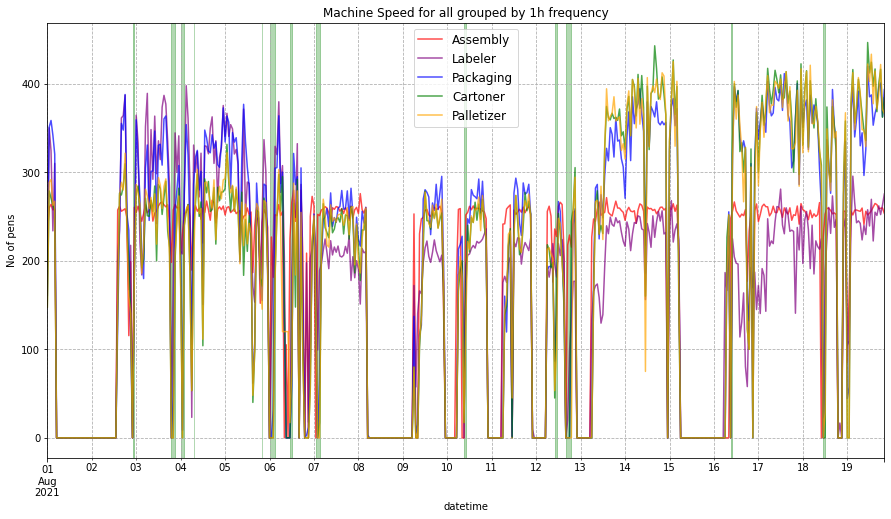

In [337]:
freq='1h'
group = df_speed.groupby(['Machine', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# control the order of the machines so they match the line design
# machines = group.Machine.unique()
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')
colors = ("red", "purple", "blue", "green", "orange")

i=0

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

for x in machines:
    # group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=x, ax=axs, alpha=0.7)
    # plt.yscale('log')
    axs.grid(True,which="both", linestyle='--')
    axs.set_title('Machine Speed for all grouped by {} frequency'.format(freq))
    axs.set_ylabel('No of pens')
    i+=1

    axs.legend()

for i, row in df_changeover3.iterrows():
    plt.axvspan(row[0], row[1], color='green', alpha=0.3)

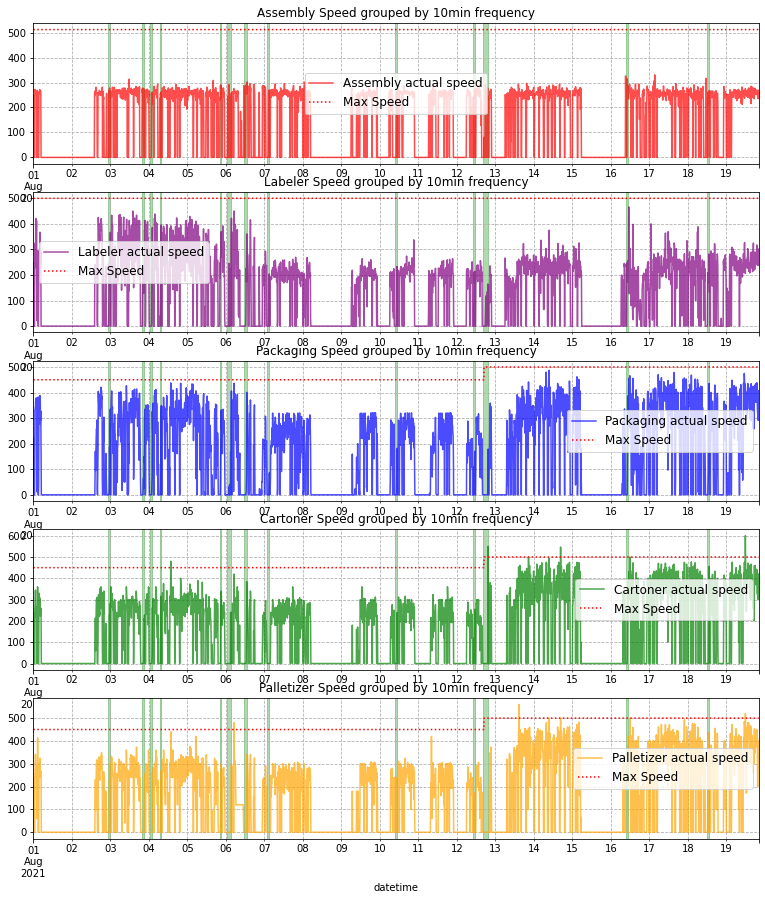

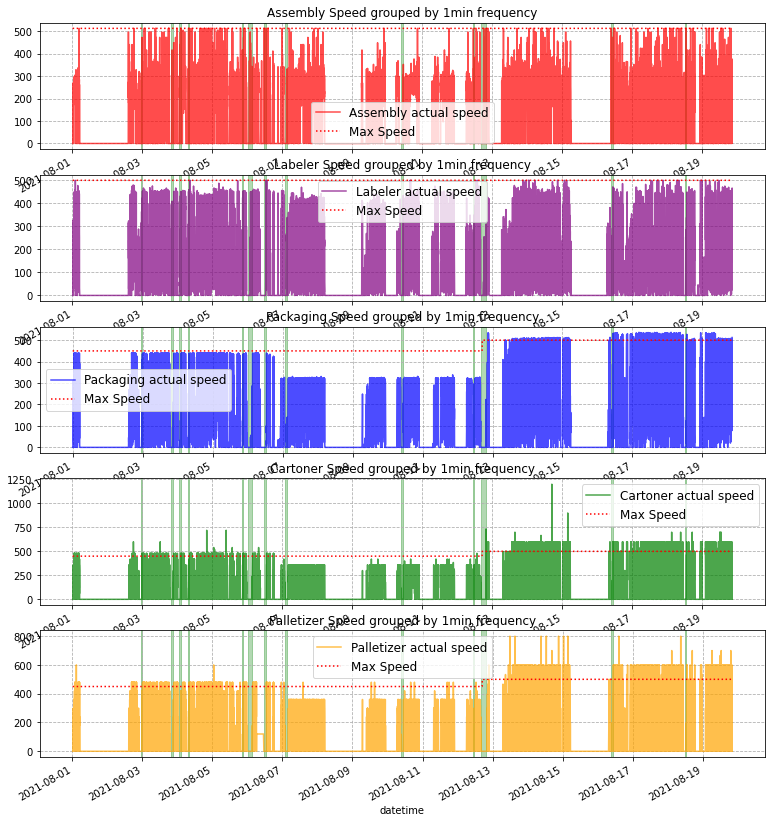

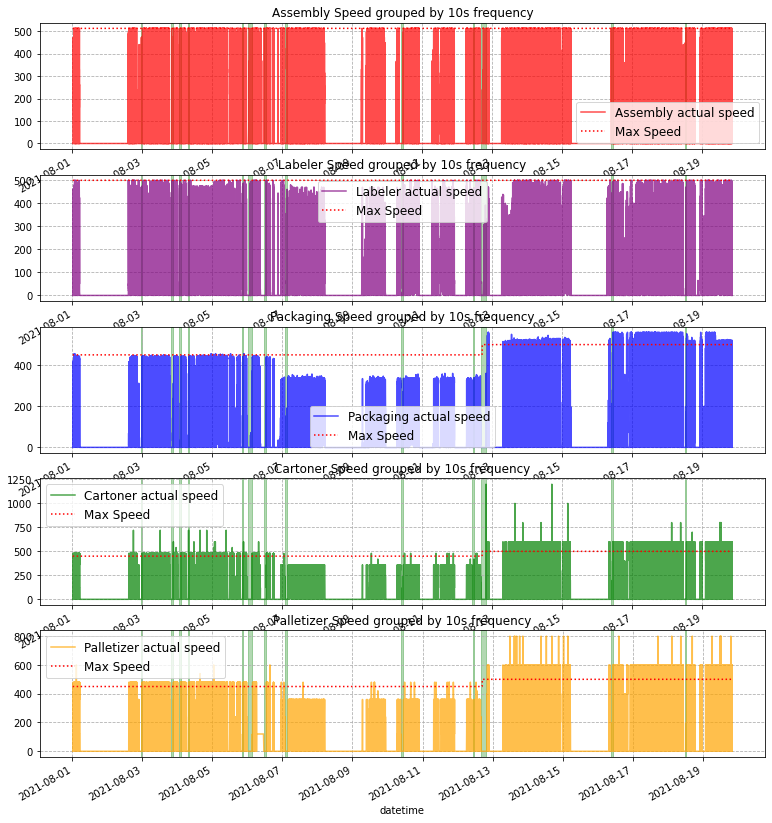

In [338]:
freq=('10min','1min','10s')

for f in freq:
    group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=f)]).mean().reset_index()
    group.set_index('datetime', inplace=True)

    # machines = group.Machine.unique()
    # control the order of the machines
    machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


    fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

    colors = ("red", "purple", "blue", "green", "orange")
    i=0

    for x in machines:
        group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
        # plt.yscale('log')

        if max(group['Max_Speed'][group.Machine == x]) > 0:
            group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

        axs[i].grid(True,which="both", linestyle='--')
        axs[i].set_title('{} Speed grouped by {} frequency'.format(x, f))
        plt.rc('legend', fontsize=12)    # legend fontsize
        axs[i].legend()

        for c, row in df_changeover3.iterrows():
            axs[i].axvspan(row[0], row[1], color='green', alpha=0.3)

        i+=1

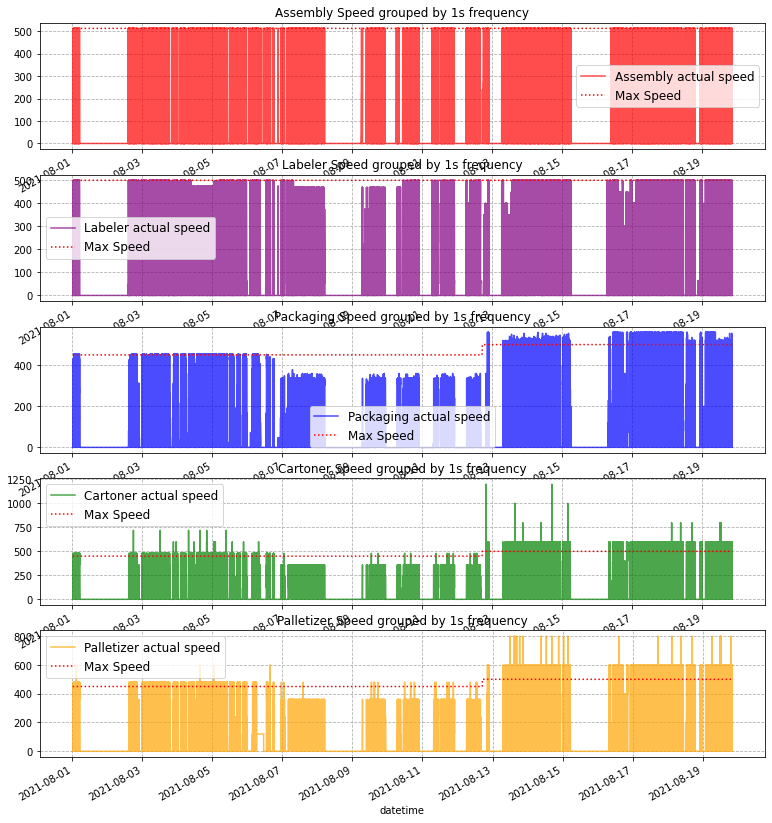

In [339]:
freq='1s'
group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

# machines = group.Machine.unique()
# control the order of the machines
machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['IP_TREND_VALUE'][group.Machine == x].plot(color=colors[i], label=('{} actual speed'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    if max(group['Max_Speed'][group.Machine == x]) > 0:
        group['Max_Speed'][group.Machine == x].plot(color='red', ls=':', label='Max Speed', ax=axs[i])

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Speed grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [340]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]
    # print('\nMax Speeds by {}\n'.format(f), round(max_hours.describe(),2))

    print('\n{} period\n'.format(f), round(max_hours.agg(['mean','max']),2))
    
# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()




Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000

1h period
          mean                                            max                                       
     Assembly Labeler Packaging Cartoner Palletizer Assembly  Labeler Cartoner Packaging Palletizer
mean   175.77  187.98    165.89   197.06     187.20   360.55   346.23    345.4    309.02     343.05
max    279.73  446.58    397.79   419.72     433.33   512.00  1200.00    500.0    560.00     800.00

30min period
          mean                                            max                                       
     Assembly Labeler Packaging Cartoner Palletizer Assembly  Labeler Cartoner Packaging Palletizer
mean   161.01  170.51    153.39   178.83     170.07    328.4   302.32   316.57    278.58     299.49
max    292.00  473.68    414.77   442.80     451.28    512.0  1200.00   500.00    560.00     800.00

10min period
          mean                                            max                                


Period: 2021-08-01 00:07:42.800000 to 2021-08-19 20:19:32.500000


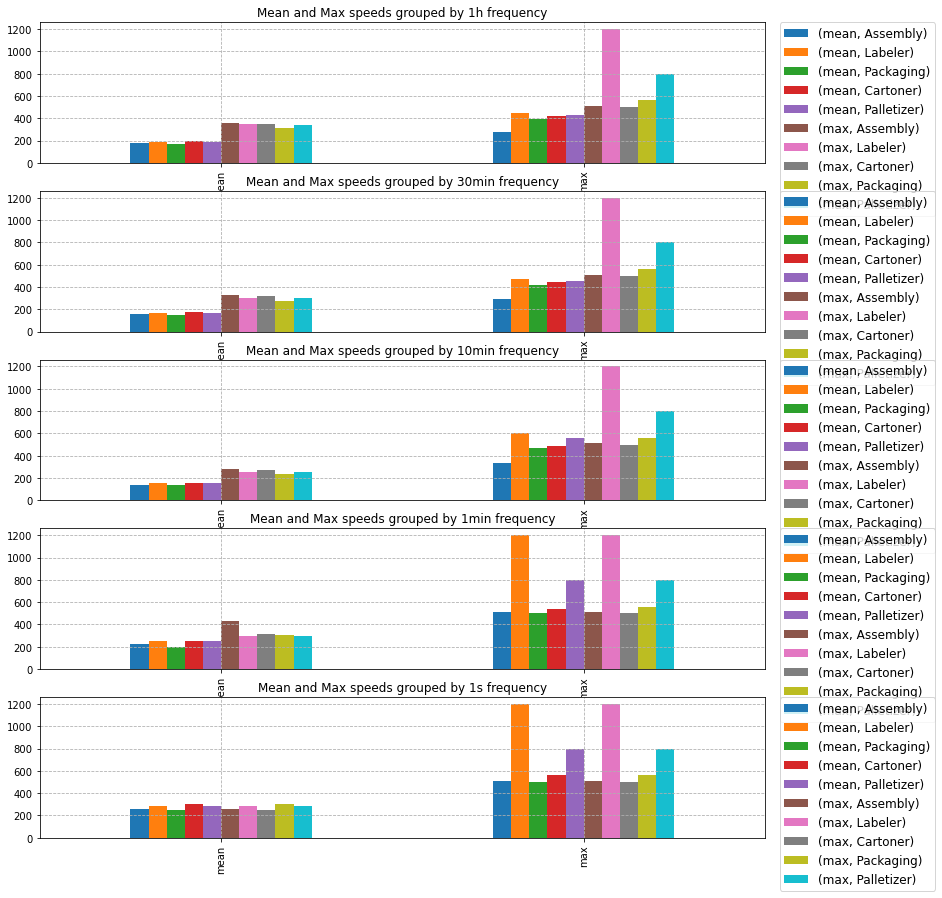

In [341]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# max speed for each our
freq=['1h','30min','10min','1min', '1s']
print('\nPeriod: {} to {}'.format(start_date, end_date))

fig, axs = plt.subplots(len(freq), 1, figsize=(13, 15))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for f in freq:
    max_hours = df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()
    max_hours.columns = [('mean',   'Assembly'),
            ('mean',    'Labeler'),
            ('mean',  'Packaging'),
            ('mean',   'Cartoner'),
            ('mean', 'Palletizer'),
            ( 'max',   'Assembly'),
            ( 'max',    'Labeler'),
            ( 'max',   'Cartoner'),
            ( 'max',  'Packaging'),
            ( 'max', 'Palletizer')]

    max_hours.agg({'mean','max'}).sort_index(ascending=False).plot.bar(ax=axs[i])

    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('Mean and Max speeds grouped by {} frequency'.format(f))
    plt.rc('legend', fontsize=12)    # legend fontsize
    #place legend outside top right corner of plot
#     handles, labels = axs[i].get_legend_handles_labels()
#     axs[i].legend(handles, labels)
    axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    i+=1

# f = '10min'
# df_speed.groupby([pd.Grouper(freq=f),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack().reset_index()



In [342]:
max_hours = df_speed.groupby([pd.Grouper(freq='1s'),'Machine'])['IP_TREND_VALUE'].agg(['mean','max']).unstack()

In [343]:
max_hours.agg({'mean','max'})

mean                                                          max                                                 
        Assembly     Cartoner     Labeler   Packaging  Palletizer    Assembly     Cartoner     Labeler   Packaging  Palletizer
mean  254.900697   285.371287  253.005197  306.683199  284.113866  255.291099   285.378713  253.149309  306.683772  284.113866
max   512.000000  1200.000000  500.000000  560.000000  800.000000  512.000000  1200.000000  500.000000  560.000000  800.000000

In [160]:
max_hours.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276168 entries, 2021-08-01 00:07:42 to 2021-08-19 20:19:31
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   (mean, Assembly)    101021 non-null  float64
 1   (mean, Cartoner)    16159 non-null   float64
 2   (mean, Labeler)     90705 non-null   float64
 3   (mean, Packaging)   96929 non-null   float64
 4   (mean, Palletizer)  16335 non-null   float64
 5   (max, Assembly)     101021 non-null  float64
 6   (max, Cartoner)     16159 non-null   float64
 7   (max, Labeler)      90705 non-null   float64
 8   (max, Packaging)    96929 non-null   float64
 9   (max, Palletizer)   16335 non-null   float64
dtypes: float64(10)
memory usage: 23.2 MB


In [161]:
# find the speed and time diff
df_speed['speed_diff'] = df_speed.groupby(['Machine'])['IP_TREND_VALUE'].diff()
df_speed['time_diff_secs'] = df_speed.groupby('Machine').IP_TREND_TIME.diff().dt.seconds
df_speed['acceleration'] = df_speed['speed_diff'] / df_speed['time_diff_secs']

In [344]:
df_speed.to_csv('df_speed_out.csv')

In [163]:
# put the datetimeindex back
df_speed.set_index('datetime', inplace=True)


KeyError: "None of ['datetime'] are in the columns"

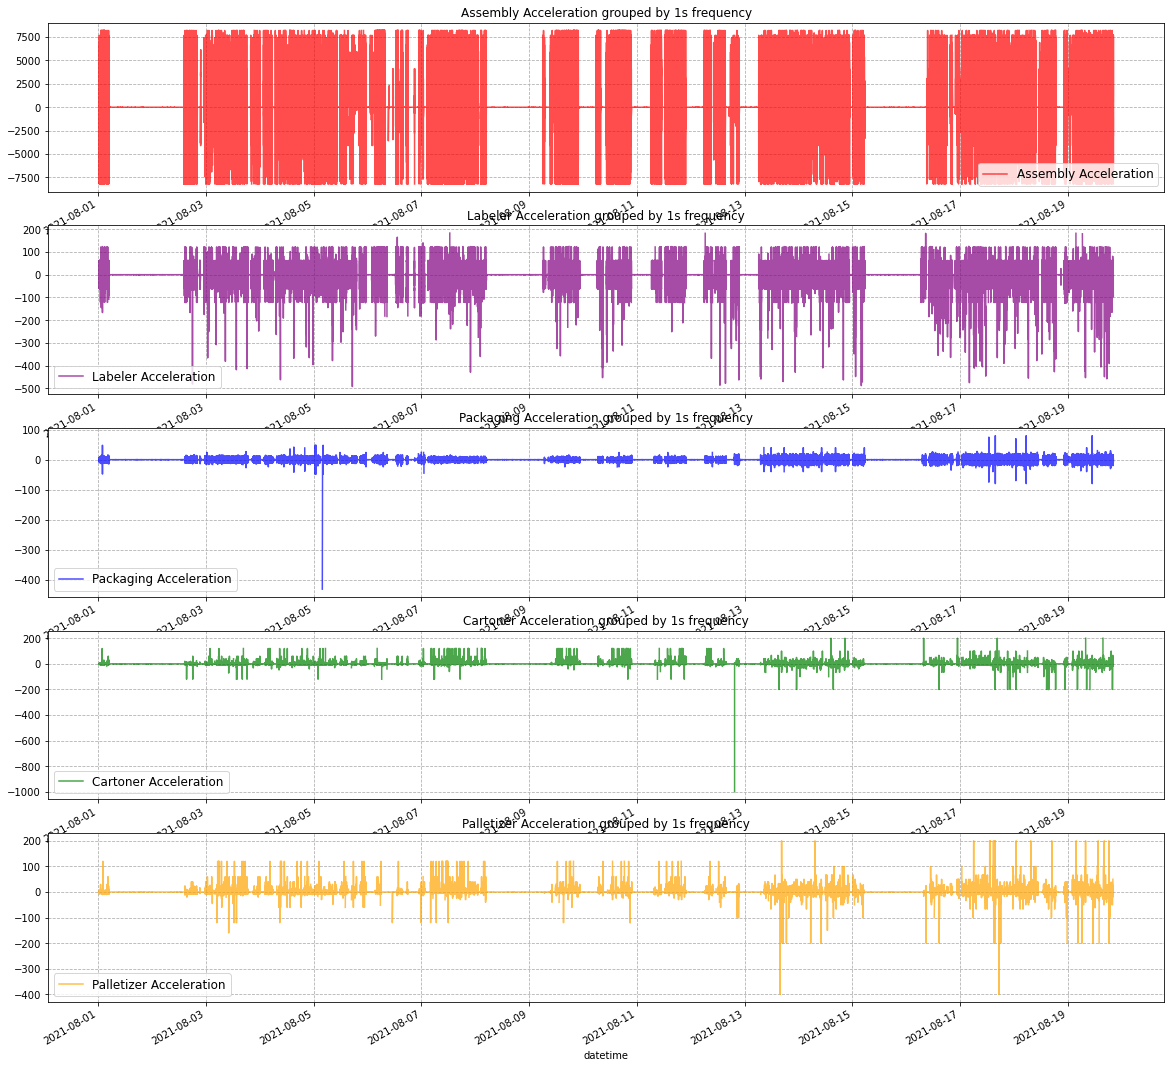

In [ ]:
freq='1s'

group = df_speed.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
group.set_index('datetime', inplace=True)

machines = ('Assembly', 'Labeler', 'Packaging', 'Cartoner', 'Palletizer')


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    group['acceleration'][group.Machine == x].plot(color=colors[i], label=('{} Acceleration'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Acceleration grouped by {} frequency'.format(x, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

KeyError: 'acceleration'

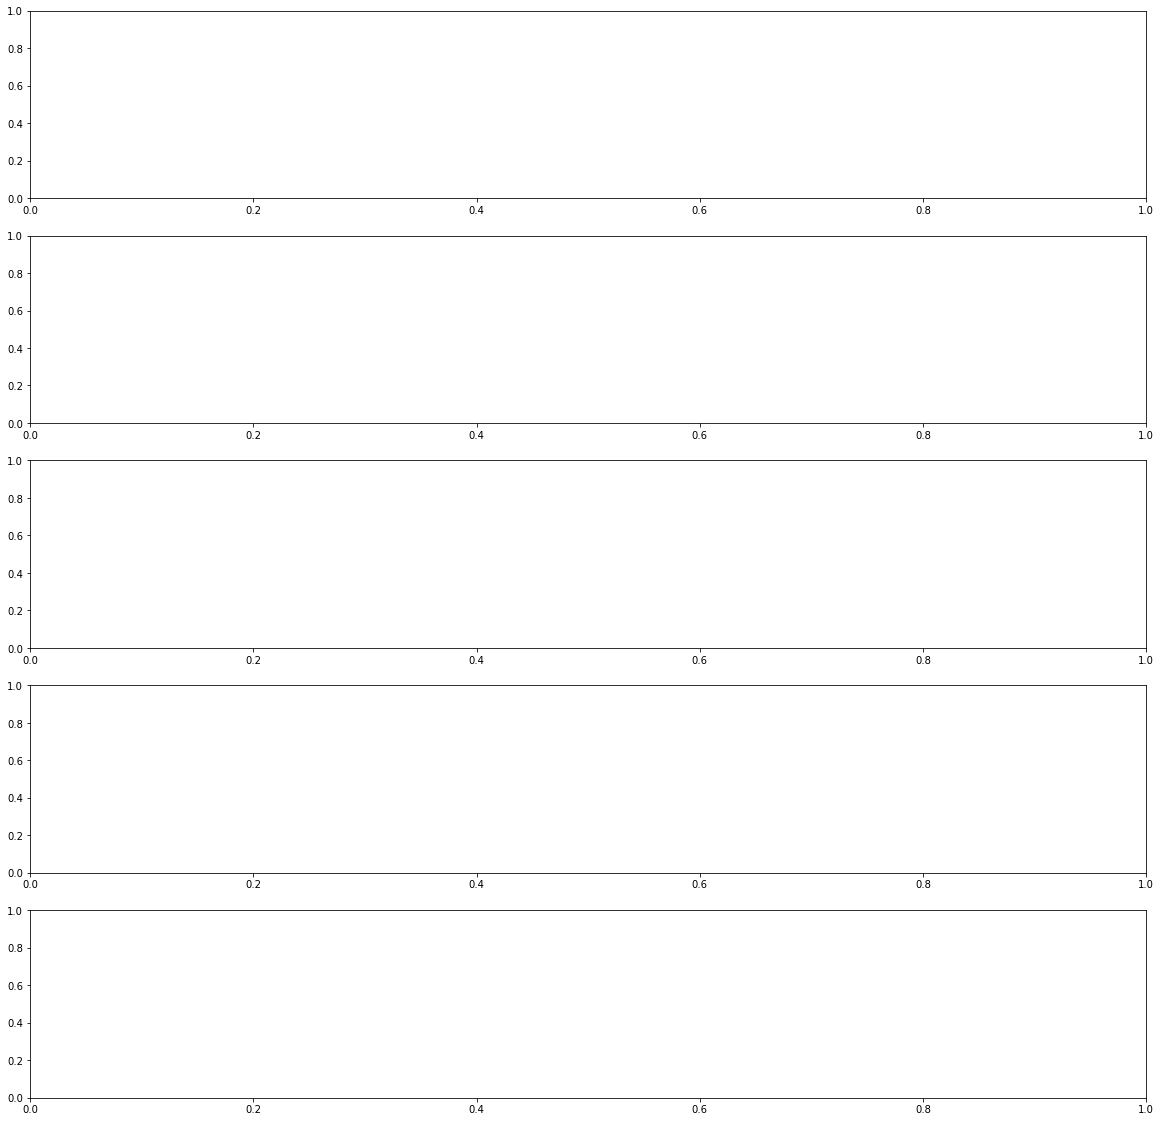

In [106]:
daterange = '2021-08-05'
times = ['08:00', '08:10']
freq='1s'

dates = group.loc[daterange]
dates = dates.between_time(times[0], times[1])

dates = dates.groupby(['Machine', 'Max_Speed', pd.Grouper(freq=freq)]).mean().reset_index()
dates.set_index('datetime', inplace=True)


fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

colors = ("red", "purple", "blue", "green", "orange")
i=0

for x in machines:
    dates['acceleration'][dates.Machine == x].plot(color=colors[i], label=('{} Acceleration'.format(x)), ax=axs[i], alpha=0.7)
    # plt.yscale('log')

    axs[i].grid(True,which="both", linestyle='--')
    axs[i].set_title('{} Acceleration for {} grouped by {} frequency'.format(x, daterange, freq))
    plt.rc('legend', fontsize=12)    # legend fontsize
    axs[i].legend()
    i+=1

In [360]:
dates

,Machine,Max_Speed,IP_TREND_VALUE,speed_diff,time_diff_secs,acceleration
datetime,,,,,,
2021-08-05 08:00:40,Assembly,512.0,6912.0,6912.0,50.0,138.240000
2021-08-05 08:00:41,Assembly,512.0,8192.0,1280.0,1.0,1280.000000
2021-08-05 08:00:42,Assembly,512.0,0.0,-8192.0,1.0,-8192.000000
2021-08-05 08:01:11,Assembly,512.0,5120.0,5120.0,29.0,176.551724
2021-08-05 08:01:12,Assembly,512.0,8192.0,3072.0,1.0,3072.000000
...,...,...,...,...,...,...
2021-08-05 08:03:43,Palletizer,450.0,0.0,0.0,599.0,0.000000
2021-08-05 08:04:38,Palletizer,450.0,120.0,120.0,54.0,2.222222
2021-08-05 08:04:44,Palletizer,450.0,240.0,120.0,6.0,20.000000


In [195]:
times[0]

'08:00'